---

## XGboost

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px
from xgboost import XGBRegressor
from sklearn.model_selection import  GridSearchCV,TimeSeriesSplit
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from useful_functions import *
file_path = "./results.json"

In [7]:
# --Tables--
series_train = pd.read_csv("series_train.csv")
series_test = pd.read_csv("series_test.csv")

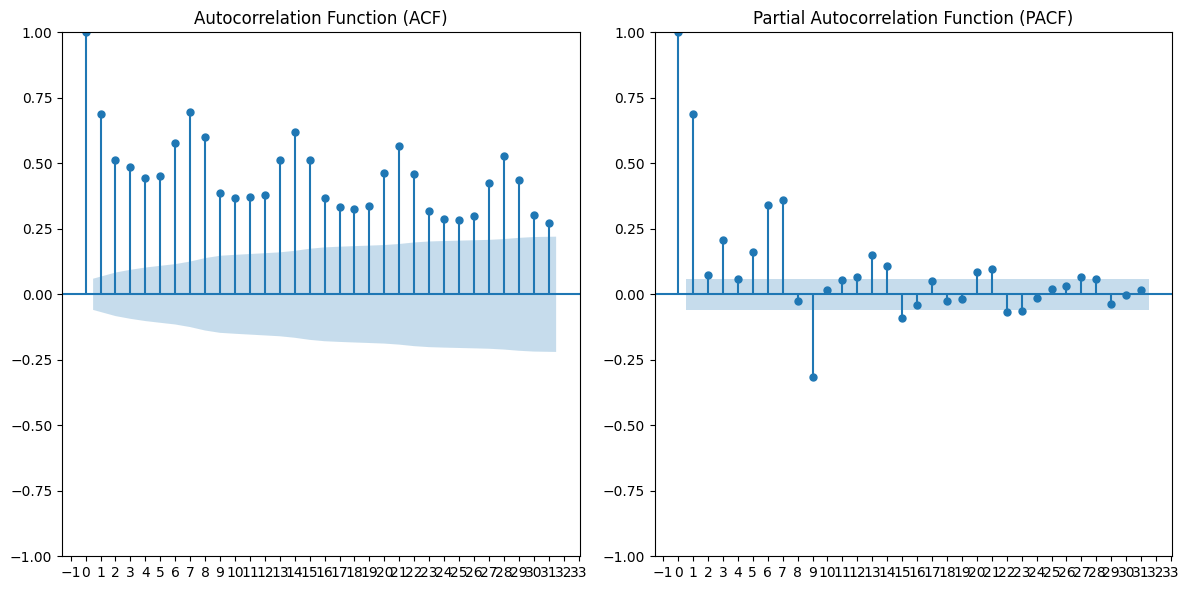

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 


plot_acf(series_train['sales'],ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1)) 

plot_pacf(series_train['sales'], ax=axes[1], method='ywm') 
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1)) 

plt.tight_layout()
plt.show()

lag = 7 semble pertinent avec une repetition hebdomadaire

In [9]:
train = series_train.copy()
test = series_test.copy()

lag = 7

train['lag'] = train['sales'].shift(lag)
test['lag'] = test['sales'].shift(lag)


X_train = train[['lag']]
y_train = train['sales']

X_test = test[['lag']]
y_test = test['sales']

Determinons les parametres du XGBoost

In [10]:
model_XGB = XGBRegressor(objective='reg:squarederror', random_state=42)

# Définir la grille de paramètres à tester
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


tscv = TimeSeriesSplit(n_splits=3)


grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)


grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Meilleurs paramètres trouvés :
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}


In [13]:
model_XGB = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    subsample=1.0
)
model_XGB.fit(X_train, y_train)

y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

series_train['train_Forecast_XGB'] = y_train_pred
series_test['test_Forecast_XGB'] = y_test_pred

In [14]:
fig = px.line(series_train, x='date', y=['sales', 'train_Forecast_XGB'],title="Predictions du train")
fig.show()

In [15]:
fig = px.line(series_test, x='date', y=['sales', 'test_Forecast_XGB'],title="Predictions du test")
fig.show()

In [18]:
nrmse, mape, mae,r2 = calculate_metrics(series_test.loc[lag:, 'sales'], series_test.loc[lag:, 'test_Forecast_XGB'])
print(nrmse)
print(mape)
print(mae)
print(r2)
        
save_model_results(
    file_path=file_path,
    model_name="XGBoost",
    params={'objective':'reg:squarederror','colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0},
    nrmse=nrmse,
    mape=mape,
    mae=mae,
    r2=r2
)

0.08277965636963118
6.332082549673071e+19
149020.86915668022
0.15924634328677134


In [ ]:
#series_train.to_csv("series_train",index =False, header=True)
#series_test.to_csv("series_test",index =False, header=True)